In [1]:
import glob
import pandas as pd
from datetime import datetime

# Functions

In [2]:
def process_a_json_heart_rate_file(Filename):
    
    df=pd.read_json(Filename)
    
    df['Date'] = pd.to_datetime(df['dateTime']).dt.date
    df['Time'] = pd.to_datetime(df['dateTime']).dt.time
    
    # An inefficient way to decode the 'value' dictionary into a dataframe
    # "pd.DataFrame.from_dict(df['value'])" did not work but should be reveiwed
    
    new=pd.Series(len(df)) 
    for i in range(len(df)):
        new.loc[i]=df.loc[i]['value']['confidence']
    df['confidence'] = pd.Series( new,index=df.index)
    for i in range(len(df)):
        new.loc[i]=df.loc[i]['value']['bpm']
    df['BPM'] = pd.Series( new,index=df.index)
    
    # Remove initial, final and some other low-confidnece readings
    # Then re-index to prevent problems

    df=df[df[:]['confidence']>1]  
    df=df.reindex()                
    
    return df 

In [3]:
def calculate_and_append_summeries(df):
    Date=df.iloc[0]['Date'] # Assumes that this json is for a single date
    Duration= datetime.combine( Date, df['Time'].max() ) - datetime.combine( Date,df['Time'].min() )
    MeanBPM=round(df['BPM'].mean(),0)
    
    s= str(df.iloc[0]['Date']) + ' ' + str(Duration) + ' ' + str(MeanBPM)   
    Summaries.append(s)

In [4]:
# Each json heart rate file covers a day
# Identifies days with more than one activity (no data for more than 20 minutes in between)
# Uses dateTime for callculation but only Time for printing

def identify_one_break_in_timed_data(df):
    
    breakExists=False
    for i in range(len(df)-1):
        delta=df.iloc[i+1]['dateTime'] - df.iloc[i]['dateTime']
        if (delta>pd.Timedelta("20 minutes")):
            print('BREAK ',i,df.iloc[i]['Time'],df.iloc[i+1]['Time'])
            breakExists=True
            break
    return breakExists,i

# Main

In [5]:
# Global parameters and variables

start=289           # File number to start from 
n_files=3         # Process and plot n files
n_plots=n_files

DFs=[]
Summaries=[]

In [6]:
files=glob.glob("FITBIT\heart_rate*.json")

len(files)

293

In [7]:
for i in range(start,start+n_files): 
    print('Main, i',i)
    df = process_a_json_heart_rate_file(files[i])
        
    breakExists,break_index=identify_one_break_in_timed_data(df)
    if (breakExists):
        df1=df[0:break_index+1]
        df2=df[break_index+1:]
        DFs.append(df1)
        DFs.append(df2)
        calculate_and_append_summeries(df1)
        calculate_and_append_summeries(df2)
        n_plots+=1
    else:
        DFs.append(df)
        calculate_and_append_summeries(df)

Main, i 289
Main, i 290
BREAK  863 10:39:22 14:32:42
Main, i 291
BREAK  1089 11:17:23 15:15:25


# Plot

n_plots 5


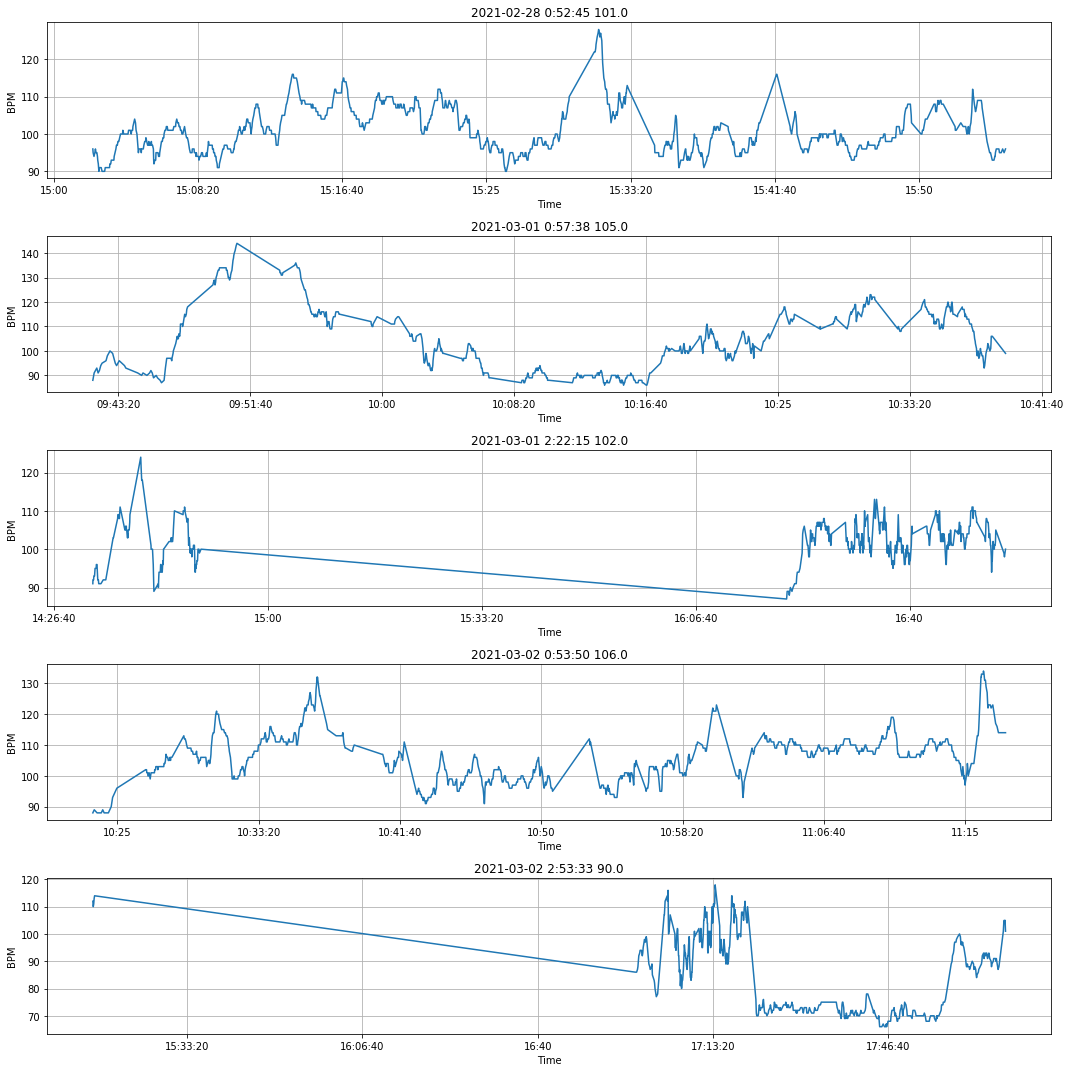

In [8]:
# From: https://matplotlib.org/stable/gallery/lines_bars_and_markers/cohere.html
%matplotlib inline

import matplotlib.pyplot as plt

print('n_plots',n_plots)
fig, axs = plt.subplots(nrows=n_plots, ncols=1, figsize=(15, 3*n_plots) )

for i in range(n_plots):
    df=DFs[i]
    #print('Plot i',i)
    axs[i].plot(df['Time'], df['BPM'])
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel('BPM')
    axs[i].set_title( Summaries[i] )
    axs[i].grid(True)

fig.tight_layout()
plt.show()